# fMRI-06 Volume Pipeline

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

In this notebook, we demonstrate a full analysis pipeline for volumetric fMRI data. 

## Step 1: Generate Design Matrix

In the first step, we design the fMRI task design matrix. Here we are analyzing a simple visual checkerboard experiment. We presented six blocks of a rotating visual checkerboard (20s duration) to one participant. The total run is 250 volumes and the repetition time (TR) was 1s.

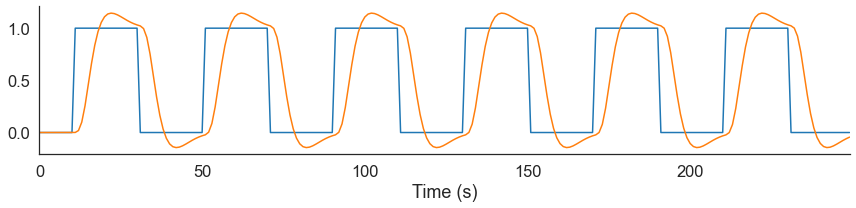

In [2]:
from pandas import read_csv
from fmritools.design import design_matrix

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define task metadata.
n_acq = 250
tr = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define experiment events.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load events.
events = read_csv('sub-01_task-visualcontrol_desc-events.tsv', sep='\t')

## Limit only to checkerboards.
events = events.query('event=="Checkerboard"')
events.event = 1

## Compute offsets (onset + duration).
events['offset'] = events['onset'].values + events['duration'].values

## Construct events matrix.
events = events[['onset','offset','event']].values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

times, X, boxcars = design_matrix(tr, n_acq, events, return_boxcars=True)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize design matrix.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,3))

## Plot.
ax.plot(times, boxcars)
ax.plot(times, X)
ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)')

sns.despine()
plt.tight_layout()

## Step 2: Prepare Nuisance Regressors

In this next section, we prepare all of the nuisance regressors. These are variables not of experimental interest, but included so as to reduce noise.

### Motion regressors

We prepare the motion regressors from the 6 degrees of observed motion (X/Y/Z-translation, pitch/yaw/roll-rotation). The motion regressors are lowpass filtered to remove high-frequency artifact and then passed through PCA for dimensionality reduction. 

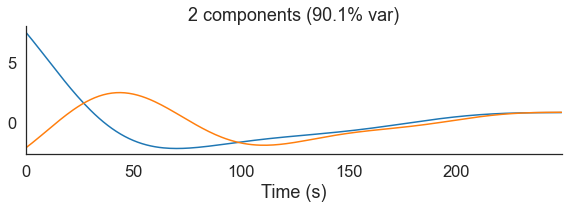

In [3]:
from pandas import read_csv
from nilearn.signal import clean
from sklearn.decomposition import PCA

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define filter level.
low_pass = 1 / 100.

## Define PCA threshold.
pca_threshold = 0.8    # Include regressors that explain 80% of motion variance.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare motion regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load fmriprep confound regressors.
confounds = read_csv('sub-01_task-visualcontrol_desc-confounds_regressors.tsv', sep='\t')

## Extract motion regressors.
cols = ['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
motion = confounds[cols].values

## Filter regressors.
motion = clean(motion, low_pass=low_pass, t_r=tr)

## Perform PCA.
pca = PCA(n_components=6)
motion = pca.fit_transform(motion)

## Take only the number of components explaining 90% of the variance.
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= pca_threshold) + 1
motion = motion[:,:n_components]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize motion regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,3))

## Plot.
ax.plot(times, motion)
ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)', 
       title='%s components (%0.1f%% var)' %(n_components, cumulative_variance[n_components-1]*100))

sns.despine()
plt.tight_layout()

### Motion scrubbers

We prepare the motion scrubbers from the framewise displacement estimates. Motion scrubbers absorb the variance from volumes "infected" with large head motion.

0 bad volumes detected.


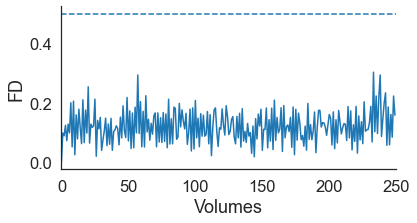

In [4]:
from pandas import read_csv

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define FD threshold.
fd_threshold = 0.5

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare motion scrubbers.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load fmriprep confound regressors.
confounds = read_csv('sub-01_task-visualcontrol_desc-confounds_regressors.tsv', sep='\t')

## Extract framewise displacement.
fd = confounds['FramewiseDisplacement'].values
fd[np.isnan(fd)] = 0

## Identify infected volumes.
bad_vols = np.argwhere(fd > fd_threshold)
print('%s bad volumes detected.' %bad_vols.size)

## Construct scrubbers.
scrubbers = np.zeros((fd.size, bad_vols.size))
scrubbers[bad_vols, np.arange(bad_vols.size)] = 1

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize framewise displacement.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(fd)
ax.hlines(fd_threshold, 0, fd.size, linestyle='--')
ax.set(xlim=(0, fd.size), xlabel='Volumes', ylabel='FD')
sns.despine()

### Prepare physiological nuisance regressors

We prepare the physiological nuisance regressors from the anatomical CompCor timeseries automatically generated by fmriprep. The physiological regressors are lowpass filtered to remove high-frequency artifact and then passed through PCA for dimensionality reduction. 

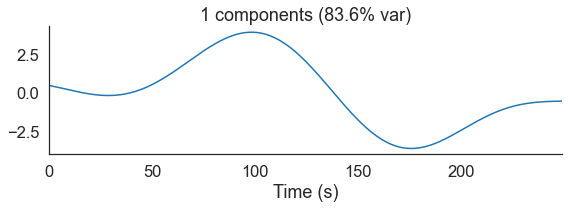

In [5]:
from pandas import read_csv
from nilearn.signal import clean

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define filter level.
low_pass = 1 / 100.

## Define PCA threshold.
pca_threshold = 0.8    # Include regressors that explain 80% of motion variance.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare physiological regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load fmriprep confound regressors.
confounds = read_csv('sub-01_task-visualcontrol_desc-confounds_regressors.tsv', sep='\t')

## Extract anatomical compcor signals.
compcor = confounds.filter(regex='aCompCor').values

## Filter regressors.
compcor = clean(compcor, low_pass=low_pass, t_r=tr)

## Perform PCA.
pca = PCA(n_components=compcor.shape[-1])
compcor = pca.fit_transform(compcor)

## Take only the number of components explaining 90% of the variance.
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= pca_threshold) + 1
compcor = compcor[:,:n_components]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize CompCor.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,3))

## Plot.
ax.plot(times, compcor)
ax.set(xlim=(times.min(), times.max()), xlabel='Time (s)', 
       title='%s components (%0.1f%% var)' %(n_components, cumulative_variance[n_components-1]*100))

sns.despine()
plt.tight_layout()

### Assemble nuisnace regressors

In this final step, we column stack our nuisance regressors into one nuisance matrix. We also include an intercept term.

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble nuisance regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define intercept.
intercept = np.ones(n_acq)

## Stack nuisance regressors.
Z = np.column_stack([intercept, motion, scrubbers, compcor])

## Step 3 (Recommended): Check Collinearity

In this optional step, we check the collinearity of our full design matrix. Collinearity is a condition in which some of the independent variables are highly correlated. Collinearity tends to create numerical instability in our regression and inflate the variance of the estimated regression coefficients. To check collinearity, we rely on the [variance inflation factor](https://en.wikipedia.org/wiki/Variance_inflation_factor). As a simple rule of thumb, VIF scores above 5 suggest problematic collinearity. VIF scores below 5 are usually ok.

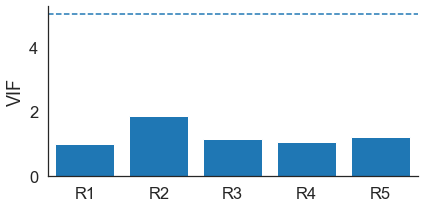

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Assemble regressors.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Assemble all regressors (design + nuisance).
XZ = np.column_stack([X,Z])

## Check variance inflation factor.
vif = [variance_inflation_factor(XZ, i) for i in range(XZ.shape[-1])]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize collinearity.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Intialize canvas.
fig, ax = plt.subplots(1,1,figsize=(6,3))

## Plot.
ax.bar(np.arange(len(vif)), vif)
ax.hlines(5,-0.5,len(vif)-0.5,linestyle='--')
ax.set(xlim=(-0.5,len(vif)-0.5), xticks=np.arange(len(vif)), 
       xticklabels=['R%s' %i for i in np.arange(len(vif))+1],
       ylabel='VIF')

sns.despine()
plt.tight_layout()

## Step 4: Prepare fMRI Data

In this next step, we prepare the fMRI data for regression analysis.

**NOTE:** In this demo, we are only analyzing one brain slice. The steps below are then for whole-brain.

### Load and mask data

Here we load the functional data and the anatomical segmentation (aseg). We mask the functional data only to voxels inside the cortex. After masking, we reshape the data to [n_times, n_voxels].

In [8]:
import nibabel as nib

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load functional data.
f = 'sub-01_task-visualcontrol_space-T1w_desc-preproc_bold.nii.gz'
func = nib.load(f).get_fdata()
print('Functional data dim:\t(X=%s, Y=%s, Z=%s, T=%s)' %func.shape)

## Load brainmask.
f = 'sub-01_task-visualcontrol_space-T1w_desc-aseg_dseg.nii.gz'
aseg = nib.load(f).get_fdata()
print('Brainmask dim:\t\t(X=%s, Y=%s, Z=%s)' %aseg.shape)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Mask data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Store dimensions of anatomical image.
brain_shape = aseg.shape

## Store indices corresponding to L/R cortex.
indices = np.where(np.logical_or(aseg == 3,    # Left cortex
                                 aseg == 42    # Right cortex
                                ))

## Apply brainmask.
raw = func[indices]

## Transpose data to shape (n_times, n_voxels)
raw = raw.T
print('Masked func dim:\t(T=%s, V=%s)' %raw.shape)

Functional data dim:	(X=50, Y=59, Z=1, T=250)
Brainmask dim:		(X=50, Y=59, Z=1)
Masked func dim:	(T=250, V=661)


### Filter BOLD data

We apply a highpass filter to the data. A 1/100s highpass filter is standard, but be careful to not filter out task-correlated signals.

In [9]:
from nilearn.signal import clean

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define metadata.
high_pass = 1 / 100.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Filter / Convert to PSC.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute mean signal.
mu = raw.mean(axis=0)

## Apply highpass data.
Y = clean(raw, detrend=True, standardize=False, high_pass=high_pass, t_r=tr)

## Convert to percent signal change.
Y = Y / mu * 100

## Step 5: fMRI First Level Analysis

Alas, the moment we've all been waiting for: fMRI regression analysis.

### Regression

Using the ordinary least squares (OLS) function from `fmritools`, we regress our design matrix against the observed BOLD data (including nuisance regressors to reduce noise).

Using the indices from the anatomical segmentation, we then extract the regression statistics ($\beta$-coefficients in percent signal change and corresponding t-statistics) and store them in new volume maps.

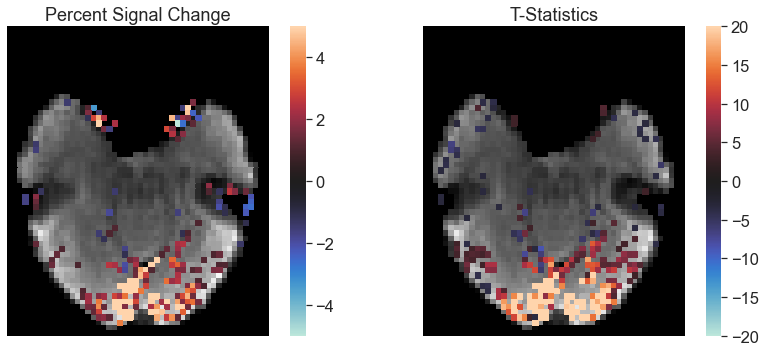

In [10]:
from fmritools.stats import OLS

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform OLS regression.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define and fit model.
fit = OLS(Y, X, Z).fit()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Extract statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Make percent signal change maps.
psc_map = np.zeros_like(aseg)            # Preallocate space, same size as anatomical image.
psc_map[indices] = fit.coef              # Store regression coeficients (PSC) in map.

## Make t-statistic maps.
t_map = np.zeros_like(aseg)              # Preallocate space, same size as anatomical image.
t_map[indices] = fit.tvalues             # Store regression coeficients (PSC) in map.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize (before multiple comparisons).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,5))

## Load BOLD reference.
f = 'sub-01_task-visualcontrol_space-T1w_desc-boldref.nii.gz'
boldref = nib.load(f).get_fdata()
boldref = boldref[:,::-1].T.squeeze()

## Make copies for visualization.
psc_viz = psc_map[:,::-1].T.squeeze().copy()
psc_viz = np.where(np.abs(psc_viz)>1, psc_viz, np.nan)
t_viz = t_map[:,::-1].T.squeeze().copy()
t_viz = np.where(np.abs(t_viz)>3, t_viz, np.nan)

## Plot percent signal change.
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax = sns.heatmap(psc_viz, center=0, vmin=-5, vmax=5, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax.set(title='Percent Signal Change')

## Plot t-statistics.
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax = sns.heatmap(t_viz, center=0, vmin=-20, vmax=20, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax.set(title='T-Statistics')

plt.tight_layout()

### Multiple comparisons correction

Next we perform multiple comparisons corrections using the FDR correction (Benjamini-Hochberg procedure).

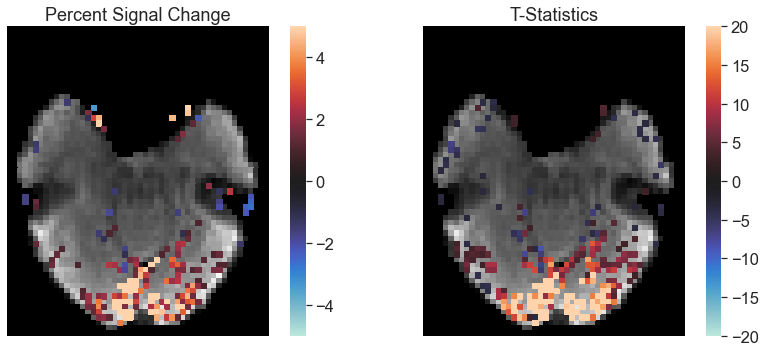

In [11]:
from mne.stats import fdr_correction

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform FDR correction.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract p-values.
p_values = fit.pvalues

## Perform corrections.
_, p_values = fdr_correction(p_values, alpha=0.001)

## Make p-value maps.
p_map = np.zeros_like(aseg)              # Preallocate space, same size as anatomical image.
p_map[indices] = p_values                # Store regression coeficients (PSC) in map.

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Mask PSC / T-maps.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Mask PSC map.
psc_map_thresh = psc_map.copy()
psc_map_thresh[p_map > 0.05] = 0

## Mask T-map.
t_map_thresh = t_map.copy()
t_map_thresh[p_map > 0.05] = 0

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Visualize (after multiple comparisons).
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,5))

## Load BOLD reference.
f = 'sub-01_task-visualcontrol_space-T1w_desc-boldref.nii.gz'
boldref = nib.load(f).get_fdata()
boldref = boldref[:,::-1].T.squeeze()

## Make copies for visualization.
psc_viz = psc_map_thresh[:,::-1].T.squeeze().copy()
psc_viz = np.where(np.abs(psc_viz)>1, psc_viz, np.nan)
t_viz = t_map_thresh[:,::-1].T.squeeze().copy()
t_viz = np.where(np.abs(t_viz)>3, t_viz, np.nan)

## Plot percent signal change.
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax = sns.heatmap(psc_viz, center=0, vmin=-5, vmax=5, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[0])
ax.set(title='Percent Signal Change')

## Plot t-statistics.
ax = sns.heatmap(boldref, cmap='binary_r', square=True, cbar=False,
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax = sns.heatmap(t_viz, center=0, vmin=-20, vmax=20, square=True, 
                 xticklabels=[], yticklabels=[], ax=axes[1])
ax.set(title='T-Statistics')

plt.tight_layout()

## Step 6: Save Maps

Finally, we can save our analysis maps for inspection in other fMRI software (e.g. Mango, Freeview).

In [12]:
from nibabel import Nifti1Image

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Save maps.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Get affine.
f = 'sub-01_task-visualcontrol_space-T1w_desc-boldref.nii.gz'
affine = nib.load(f).affine

## PSC map.
f = 'sub-01_task-visualcontrol_space-T1w_psc.nii.gz'
obj = Nifti1Image(psc_map_thresh, affine)
nib.save(obj, f)

## T-map map.
f = 'sub-01_task-visualcontrol_space-T1w_tvalues.nii.gz'
obj = Nifti1Image(t_map_thresh, affine)
nib.save(obj, f)